Učitavanje potrebnih biblioteka

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from model import Net

import warnings
warnings.filterwarnings("ignore")

## Train / test dataset and dataloaders

Učitavanje trening podataka i odgovarajućih labela

In [2]:
train_data = np.load('./data/train_data.npy', allow_pickle=True)
train_labels = np.load('./data/train_labels.npy', allow_pickle=True)

Provera balansiranosti klasa

In [3]:
unique, counts = np.unique(train_labels, return_counts=True)

unique, counts, np.sum(counts), len(train_labels), len(unique)

(array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
        'del', 'nothing', 'space'], dtype='<U7'),
 array([3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
        3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000,
        3000, 3000, 3000, 3000, 3000, 3000, 3000], dtype=int64),
 87000,
 87000,
 29)

Učitavanje test podataka i odgovarajućih labela

In [4]:
test_data = np.load('./data/test_data.npy', allow_pickle=True)
test_labels = np.load('./data/test_labels.npy', allow_pickle=True)

In [5]:
labels_map = {} # mapa svih labela
for i, label in enumerate(train_labels):
    if label not in labels_map:
        labels_map[i] = label

Prikaz primera podataka iz različitih klasa

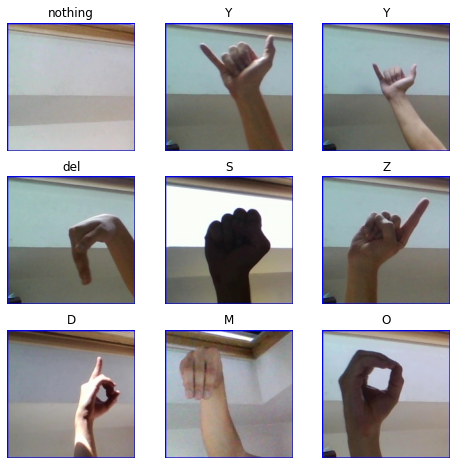

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(train_labels[sample_idx])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Formiranje klase ASLDataset za formiranje dataseta sa enkodovanim labelama i funkcionalnostima za pristup podacima i dužinom dataseta

In [7]:
class ASLDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels_non_encoded = labels

        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(labels)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label    

In [8]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
])

dataset = ASLDataset(train_data, train_labels, transform=data_transform)        # trening dataset
test_dataset = ASLDataset(test_data, test_labels, transform=data_transform)     # test dataset

Podela na trening, validacioni i test set podataka, i formiranje dataloadera

In [24]:
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_size = int(0.8 * len(train_dataset))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [25]:
len(train_dataset), len(val_dataset), len(test_dataset)

(55680, 31320, 17400)

Feature batch shape: torch.Size([64, 3, 28, 28])
Labels batch shape: torch.Size([64])


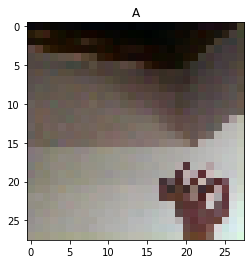

In [47]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = img.permute((1, 2, 0))
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.title(labels_map[label.item()])
plt.show()


## Defining and training the model

Formiranje mreže i definisanje parametara

In [48]:
net = Net(input_shape=[3, 28, 28], num_classes=29, conv_layers=[16, 32], fc_layers=[120, 84])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=29, bias=True)
)

Treniranje mreže

In [49]:
loss_tr, loss_val = [], []
acc_tr, acc_val = [], []

for epoch in range(10):
    
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
    
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()

            pred = torch.argmax(outputs, axis=1)
            correct += torch.sum(pred == labels).item()
            total += len(labels)

        loss_tr.append(running_loss / total)
        acc_tr.append(correct / total)

        net.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                pred = torch.argmax(outputs, axis=1)
                correct += torch.sum(pred == labels).item()
                total += len(labels)

        loss_val.append(running_loss / total)
        acc_val.append(correct / total)

        print(f"Epoch {epoch+1}")
        print(f"Loss: {loss_tr[-1]}, Val Loss: {loss_val[-1]}")
        print(f"Acc: {acc_tr[-1]}, Val Acc: {acc_val[-1]}")
        print("---------------------------------------------------")

Epoch 1
Loss: 0.013157316802561969, Val Loss: 0.005566093776646245
Acc: 0.7346982758620689, Val Acc: 0.8749680715197956
---------------------------------------------------
Epoch 2
Loss: 0.0032709758823079153, Val Loss: 0.0017420802795296085
Acc: 0.9283764367816092, Val Acc: 0.9621647509578544
---------------------------------------------------
Epoch 3
Loss: 0.0018135326777667814, Val Loss: 0.002301045274451175
Acc: 0.9601293103448276, Val Acc: 0.9516922094508301
---------------------------------------------------
Epoch 4
Loss: 0.001466803927830589, Val Loss: 0.0017363398003280115
Acc: 0.9680136494252873, Val Acc: 0.9627394636015326
---------------------------------------------------
Epoch 5
Loss: 0.0012819052245012946, Val Loss: 0.0016711998676630225
Acc: 0.9717672413793104, Val Acc: 0.9672733077905492
---------------------------------------------------
Epoch 6
Loss: 0.0010593737981002176, Val Loss: 0.002545428833011942
Acc: 0.9773347701149425, Val Acc: 0.9549808429118773
-------------

Prikaz rezultata treniranja - trening i validaciona loss funkcija i tačnost

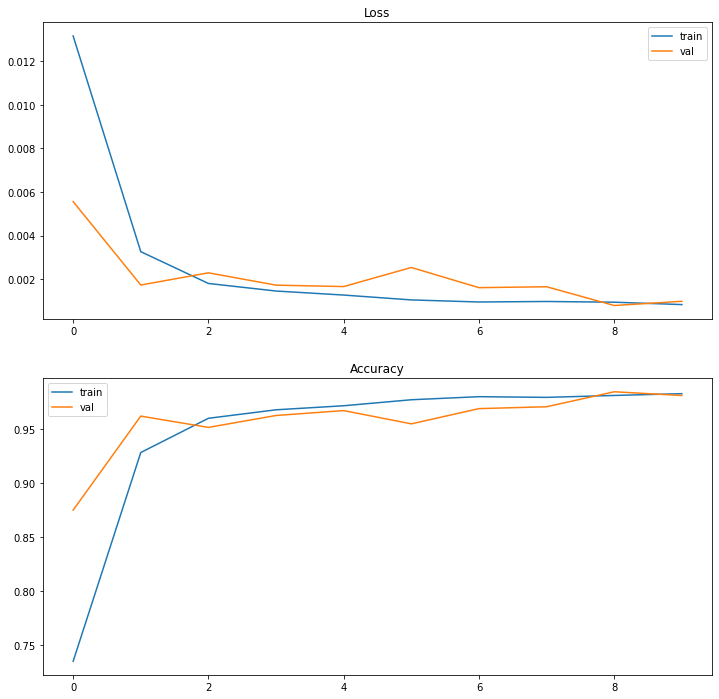

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(loss_tr, label='train')
ax[0].plot(loss_val, label='val')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(acc_tr, label='train')
ax[1].plot(acc_val, label='val')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

Evaluacija modela na test setu i prikaz tačnosti

In [ ]:
# net.load_state_dict(torch.load('model.pth'))

In [51]:
net.eval()
correct = 0
total = 0
preds = []
labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels_batch = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch.to(device)).sum().item()
        preds.extend(predicted.cpu().numpy())
        labels.extend(labels_batch.cpu().numpy())

def f1_score(labels, preds):
    cm = confusion_matrix(labels, preds)
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    f1 = 2 * p * r / (p + r)
    f1 = np.nan_to_num(f1)
    return np.mean(f1)

print(f'Accuracy of the network on the test images: {100 * correct / total}%')
print(f'F1 score: {f1_score(labels, preds)}')

Accuracy of the network on the test images: 98.52873563218391%
F1 score: 0.9853052656905201


Prikaz matrice konfuzije

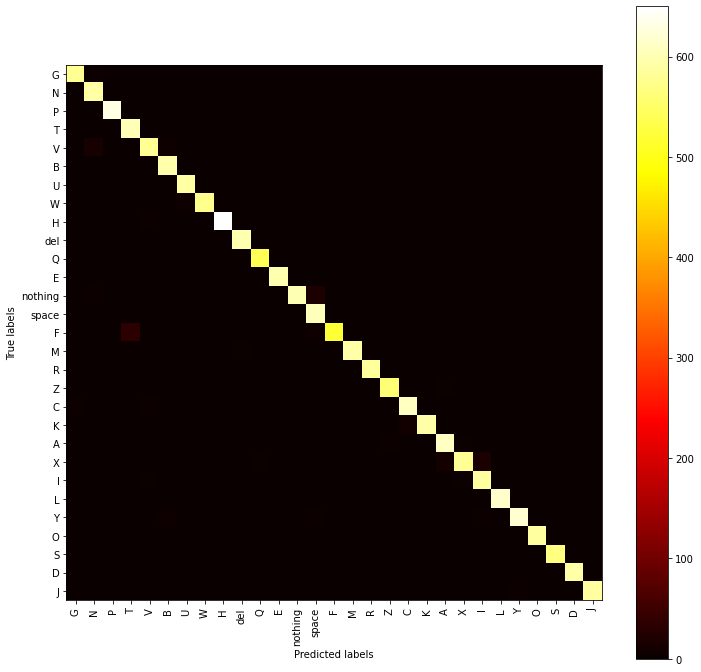

In [67]:
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(12, 12))    
plt.imshow(cm, cmap='hot')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.yticks(np.arange(0, 29), set(labels_map.values()))
plt.xticks(np.arange(0, 29), set(labels_map.values()), rotation=90)
plt.colorbar()
plt.show()

In [69]:
accs = []
for i in range(29):
    accs.append(cm[i][i] / np.sum(cm[i]) * 100)

print(accs)

[98.80749574105621, 99.83108108108108, 100.0, 99.83443708609272, 96.02649006622516, 99.66555183946488, 99.66216216216216, 98.62778730703259, 99.23664122137404, 99.00662251655629, 99.63099630996311, 99.83333333333333, 95.38950715421304, 99.67051070840198, 91.37323943661971, 98.83333333333333, 100.0, 98.76325088339223, 98.06138933764136, 98.01324503311258, 98.54838709677419, 94.77977161500816, 98.98819561551433, 98.87459807073955, 98.09825673534073, 99.1554054054054, 99.29947460595446, 100.0, 99.32546374367622]


Čuvanje modela

In [53]:
torch.save(net.state_dict(), 'model.pth')